Package Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt

Global Declarations

In [6]:
DATA = '../data/data.csv'
NEIGHBOURHOOD = []
ROOM_TYPE = []

Data Preprocessing

In [7]:
#read data from csv file
def read_data(file_name):
    data = pd.read_csv(file_name)
    return data 

In [8]:
def df_cleanup():
    
    df = pd.DataFrame(read_data(DATA))

    df = df.drop(df[df.availability_365 < 1].index)
    
    df = df.drop('license', axis=1)
    df = df.drop('last_review', axis=1)
    df = df.drop('reviews_per_month', axis=1)
    df = df.drop('calculated_host_listings_count', axis=1)
    df = df.drop('minimum_nights', axis=1)
    df = df.drop('number_of_reviews_ltm', axis=1)
    df = df.drop('name', axis=1)
    df = df.drop('host_name', axis=1)
    df = df.drop('availability_365', axis=1)

    df = df.replace('Studio', 0)
    df = df.replace('No rating', -1)
    df = df.replace('Not specified', -1)

    df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df['baths'] = pd.to_numeric(df['baths'], errors='coerce')

    df = df.replace('Manhattan', 1)
    df = df.replace('Queens', 2)
    df = df.replace('Staten Island', 3)
    df = df.replace('Brooklyn', 4)
    df = df.replace('Bronx', 5)

    for i in df['neighbourhood']:
        if i in NEIGHBOURHOOD:
            df = df.replace(i, NEIGHBOURHOOD.index(i))
        else:
            NEIGHBOURHOOD.append(i)
            df = df.replace(i, NEIGHBOURHOOD.index(i))
    
    room_type = []

    for i in df['room_type']:
        if i in ROOM_TYPE:
            df = df.replace(i, ROOM_TYPE.index(i))
        else:
            ROOM_TYPE.append(i)
            df = df.replace(i, ROOM_TYPE.index(i))

    df['neighbourhood_group'] = pd.to_numeric(df['neighbourhood_group'], errors='coerce')
    df['neighbourhood'] = pd.to_numeric(df['neighbourhood'], errors='coerce')
    df['room_type'] = pd.to_numeric(df['room_type'], errors='coerce')

    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df[df['price'] <= 1000]

    return df


In [9]:
DF = df_cleanup()

Dataframe Visualization

In [10]:
print(DF.shape)
print(DF.dtypes)
print(ROOM_TYPE)
print(NEIGHBOURHOOD)
print(DF)

(17963, 13)
id                       int64
host_id                  int64
neighbourhood_group      int64
neighbourhood            int64
latitude               float64
longitude              float64
room_type                int64
price                  float64
number_of_reviews        int64
rating                 float64
bedrooms                 int64
beds                     int64
baths                  float64
dtype: object
['Entire home/apt', 'Private room', 'Hotel room', 'Shared room']
["Hell's Kitchen", 'Chelsea', 'Washington Heights', 'Murray Hill', 'Williamsburg', 'Sunset Park', 'Astoria', 'Financial District', 'Midtown', 'Upper West Side', 'Concourse Village', 'Flushing', 'Greenpoint', 'Cypress Hills', "Prince's Bay", 'Port Richmond', 'East Village', 'Clason Point', 'Bedford-Stuyvesant', 'Gravesend', 'Long Island City', 'Gramercy', 'East Flatbush', 'Kensington', 'St. George', 'South Ozone Park', 'Wakefield', 'Forest Hills', 'Springfield Gardens', 'North Riverdale', 'Belmont', 'C

In [11]:
#chech if there is entries with price > 3000
def check_price(df):
    if df[df['price'] > 3000].empty:
        print("No entries with price > 3000")
    else:
        print("There are entries with price > 3000")
        print(df[df['price'] > 3000])

check_price(DF)

No entries with price > 3000


In [12]:
X = DF.drop('price', axis = 1)
X = X.drop('id', axis = 1)
y = DF[['price']]

print(DF.shape)
print(DF.dtypes)
print(DF)

(17963, 13)
id                       int64
host_id                  int64
neighbourhood_group      int64
neighbourhood            int64
latitude               float64
longitude              float64
room_type                int64
price                  float64
number_of_reviews        int64
rating                 float64
bedrooms                 int64
beds                     int64
baths                  float64
dtype: object
                       id    host_id  neighbourhood_group  neighbourhood  \
1                45277537   51501835                    1              0   
2      971353993633883038  528871354                    1              1   
3                 3857863   19902271                    1              2   
4                40896611   61391963                    1              3   
5                49584983   51501835                    1              0   
...                   ...        ...                  ...            ...   
20750  791754056397616680  429183811   

### Polynomial Regression

In [13]:
# from sklearn.model_selection import kfold
pca = PCA(n_components=2)
PolynomialFeatures(degree=3, include_bias=False)

poly = PolynomialFeatures(degree=3, include_bias=False)

poly_features = poly.fit_transform(X)
poly_features = pca.fit_transform(poly_features)

# k = 5
# kf = kfold.KFold(n_splits=k, shuffle=True)

X_train,X_test, y_train, y_test = train_test_split(poly_features, y, test_size = 0.3)

reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(X_train, y_train)

print('Intercept: ',reg_model.intercept_)
list(zip(X, reg_model.coef_))

y_pred= reg_model.predict(X_test)  
x_pred= reg_model.predict(X_train)

y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)

reg_model_diff = pd.DataFrame({'Actual value': y_test.iloc[:, 0], 'Predicted value': y_pred.iloc[:, 0]})
reg_model_diff.dropna(inplace=True)
print(reg_model_diff)

Intercept:  [159.79895752]
      Actual value  Predicted value
4             85.0       159.507218
6            105.0       159.912925
7            130.0       159.763439
12           100.0       156.614207
15          1000.0       159.731030
...            ...              ...
5381          50.0       159.760351
5383          34.0       159.741208
5384         616.0       159.211427
5385         155.0       159.763219
5387          69.0       159.728450

[1371 rows x 2 columns]


### SVM regression

In [ ]:
from sklearn import svm

regr = svm.SVR(kernel='linear')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print('SVM model score: ', regr.score(X_test, y_test))

/Users/augustpallesen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
#evcaluation metrics
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2 score:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 16963.964231747388
Mean Absolute Error: 86.97421482301809
Root Mean Squared Error: 130.2457839307952
R^2 score: 0.00045819858995921336


Correlation Matrix

In [44]:
# numerical_columns = DF.select_dtypes(include='number')
# correlation_matrix = numerical_columns.corr()
# # Heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title('Correlation Matrix of Numerical Features')
# plt.xticks(rotation = 25)
# plt.show()

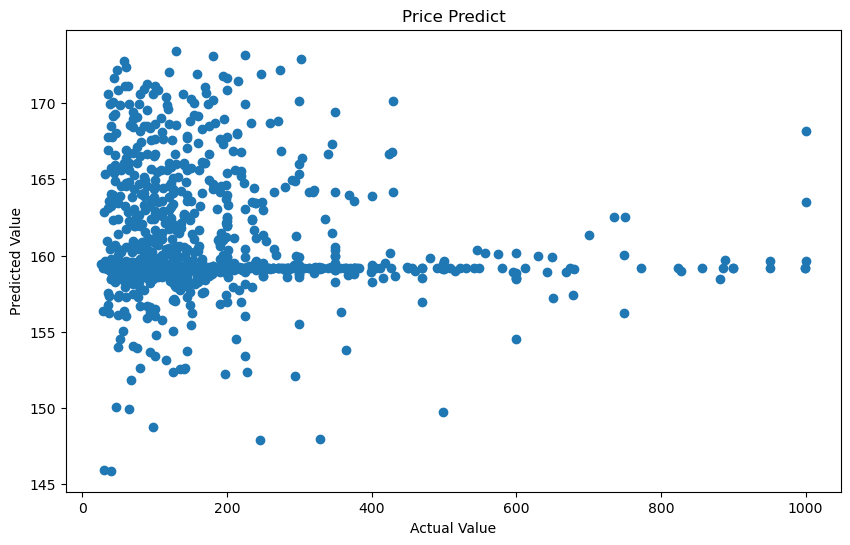

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(reg_model_diff.iloc[:, 0], reg_model_diff.iloc[:, 1])
plt.title("Price Predict")
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()